In [1]:
# Import modules
import numpy as np
import h5py
import glob
import re
import tensorflow as tf
import random
import cmcrameri as cmc

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import pearsonr

from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,BatchNormalization,AveragePooling2D,LeakyReLU,GlobalAveragePooling2D,ReLU

np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.append('./../..')
from src.training_utils import data_load, extract_floats, split_dataset, predict_multi_by_name, plot_violin_and_statistics,cross_mean_err_calculator

In [2]:
# Define data loading
def data_load():
    density = 0.15
    files = glob.glob(f"../data/testData/dataset_tumble_*_0.1_1000.h5") #imports all tumbling rates for density 0.1. Use test set here.
    inputs,outputs = [],[]
    for f in files:
        tumble = float(extract_floats(f)[0])
        with h5py.File(f, "r") as fin:
          count = 0
          for key in fin.keys():
              img = fin[key][:]
              img = img.reshape((img.shape[0], img.shape[1],1))
              shape = img.shape
              inputs.append(img)
              outputs.append(tumble)
              count+=1

    # Scramble the dataset
    order = np.arange(len(outputs)).astype(int)
    order = np.random.permutation(order)
    return np.array(inputs)[order],np.array(outputs)[order],shape

In [3]:
# Load data
x,y,shape = data_load()
x_train, y_train, x_val, y_val = split_dataset(x,y,last=int(len(x)*1)) #len(x)*1 means no training, only validation!

Number of unique alpha:  10
Shape of x:  (140000, 128, 128, 1)
Shape of y:  (140000,)
Size of training data:  0
Size of validation data:  140000


In [4]:
# Load models for comparison and make predictions
# Uncomment some model lines to add more models for comparison
name1 = "modelName1"
name2 = "modleName2"
# name3 = "modelName3"
# name4 = "modelName4"
# name5 = "modelName5"

model1 = tf.keras.models.load_model(f'../models/{name1}.keras')
model2 = tf.keras.models.load_model(f'../models/{name2}.keras')
# model3 = tf.keras.models.load_model(f'../models/{name3}.keras')
# model4 = tf.keras.models.load_model(f'../models/{name4}.keras')
# model5 = tf.keras.models.load_model(f'../models/{name5}.keras')

prediction1 = model1.predict(x_val)
prediction2 = model2.predict(x_val)
# prediction3 = model3.predict(x_val)
# prediction4 = model4.predict(x_val)
# prediction5 = model5.predict(x_val)

v = prediction1.T[0]
v2 = prediction2.T[0]
# v3 = prediction3.T[0]
# v4 = prediction4.T[0]
# v5 = prediction5.T[0]

vArray = [v, v2]
# vArray = [v,v2,v3,v4,v5]

colours = ["blue","orange","green","cyan","purple"]
labels = ["label1", "label2", "label3", "label4", "label5"]

4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step


PLot Violin plot comparison

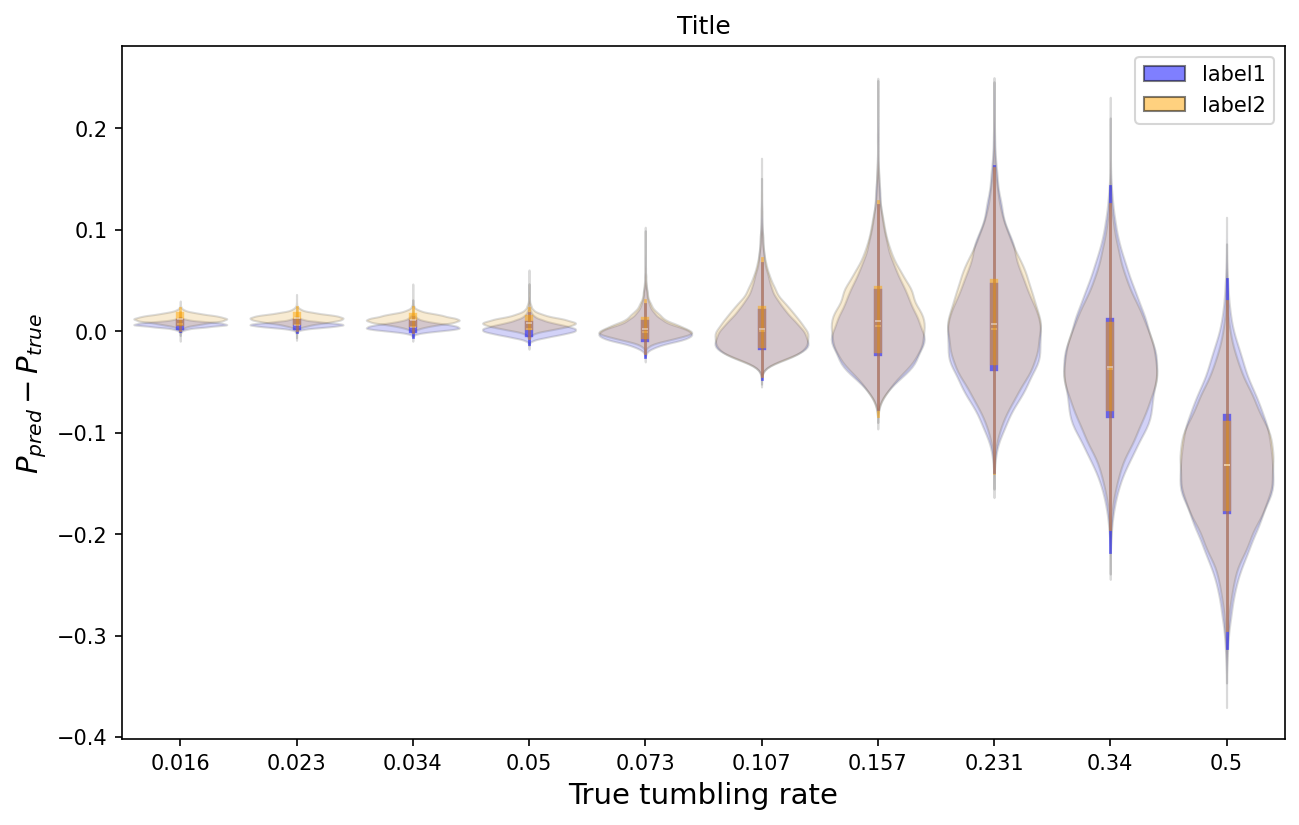

In [5]:
from cmcrameri import cm
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

bins = np.logspace(-6,-1,10, base=2)*0.85

colors = cm.batlowS(np.digitize(v, bins))
colors_actual = cm.batlowS(np.digitize(np.unique(y_val),bins))

fig, ax1 = plt.subplots(figsize=(10,6),dpi=150)

df = pd.DataFrame()
df.insert(0, "actual", y_val)

patches = []

for i in range(0,len(vArray)):
    df.insert(i+1, ("predicted"+str(i+1)), vArray[i] - y_val)

    sns.violinplot(
        ax=ax1,
        data=df,
        x="actual",
        y=("predicted"+str(i+1)),
        color=colours[i],
        alpha=0.2,
        density_norm="width",
        linewidth=1,
        inner="box",
        inner_kws={"box_width": 4, "color": colours[i], "alpha": 0.5},
        )
    
    
    patches.append(mpatches.Patch(edgecolor="black", facecolor=colours[i], label=labels[i], alpha=0.5))

ax1.set_xlabel("True tumbling rate",fontsize=14)
ax1.set_ylabel(r"$P_{pred}-P_{true}$",fontsize=14)
ax1.set_title("Title")
ax1.legend(handles=patches)

# plt.savefig("violin.png")

Plot line plot

<>:54: SyntaxWarning: invalid escape sequence '\s'
<>:54: SyntaxWarning: invalid escape sequence '\s'
/var/folders/9r/jfvt26md19j8qqcl8qtttkyr0000gn/T/ipykernel_2765/1755930595.py:54: SyntaxWarning: invalid escape sequence '\s'
  ax2.text(i,height,f"${std_div[counter]:.3f} \sigma$",ha="center", color=currentColor)


Prediction means and standard deviations.
Actual value 0.016: Average = 0.02269 +- 0.00253; Expected value within 2.645 stdevs of mean
Actual value 0.023: Average = 0.02951 +- 0.00261; Expected value within 2.497 stdevs of mean
Actual value 0.034: Average = 0.03856 +- 0.00373; Expected value within 1.222 stdevs of mean
Actual value 0.05: Average = 0.05266 +- 0.00613; Expected value within 0.434 stdevs of mean
Actual value 0.073: Average = 0.07446 +- 0.01194; Expected value within 0.122 stdevs of mean
Actual value 0.107: Average = 0.11185 +- 0.02582; Expected value within 0.188 stdevs of mean
Actual value 0.157: Average = 0.16850 +- 0.04350; Expected value within 0.264 stdevs of mean
Actual value 0.231: Average = 0.23752 +- 0.05792; Expected value within 0.113 stdevs of mean
Actual value 0.34: Average = 0.30484 +- 0.06374; Expected value within 0.552 stdevs of mean
Actual value 0.5: Average = 0.36878 +- 0.06619; Expected value within 1.983 stdevs of mean
With accuracy 0.005, overlap rat

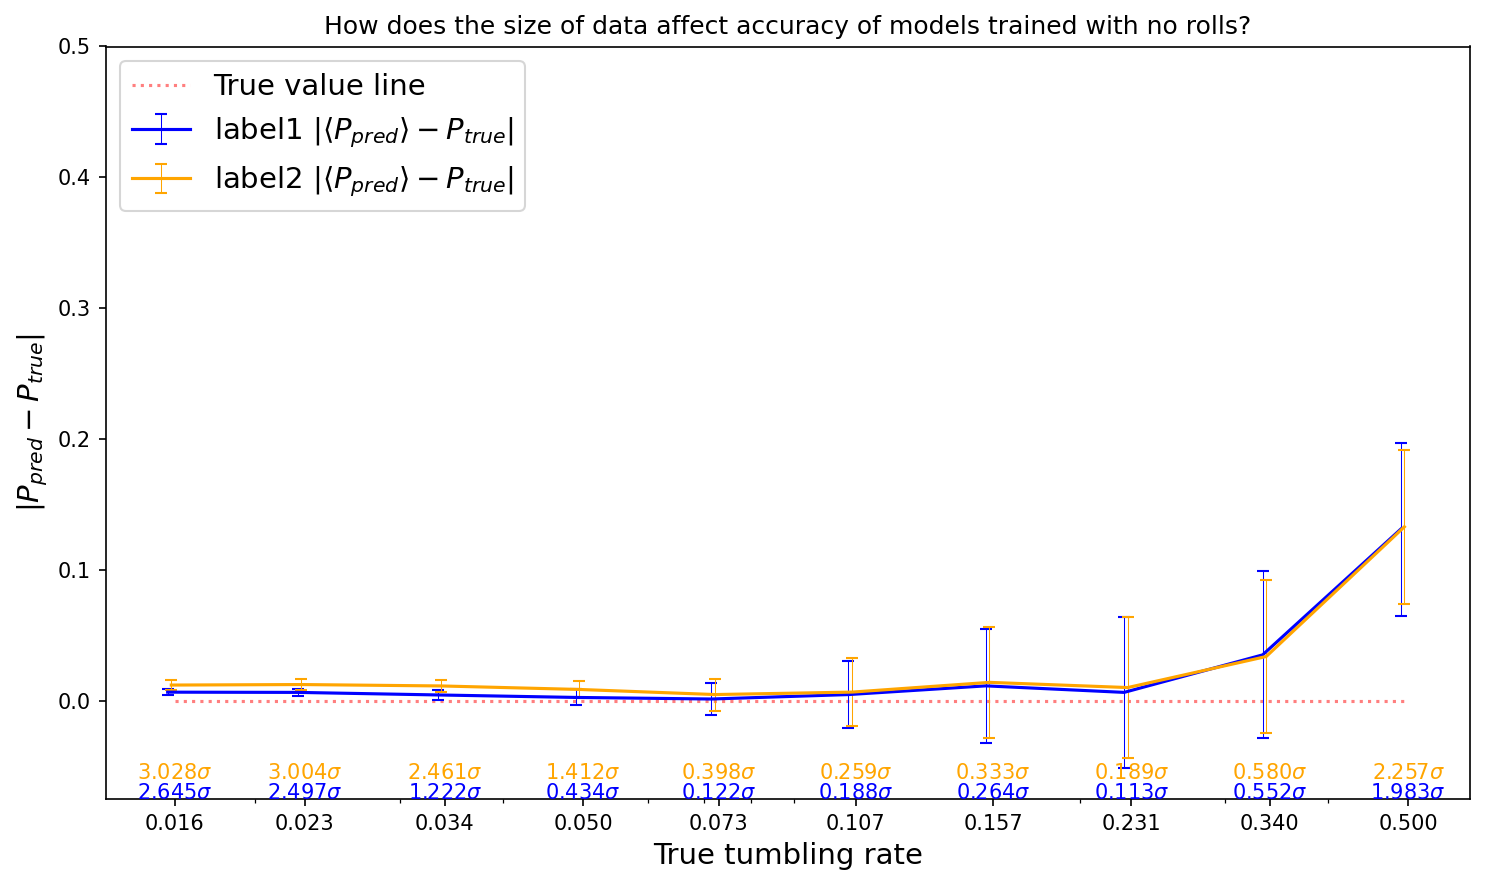

In [8]:
fig, ax2 = plt.subplots(figsize=(10,6),dpi=150)

ax2.plot(np.sort(np.unique(y_val)),np.zeros(np.unique(y_val).shape[0]),color='red',label='True value line',linestyle='dotted',alpha=0.5)

# probably will need to edit these for z score label placements
heights = [-0.075,-0.06,-0.045,-0.03,-0.015]
offsets = [0.98,0.99,1,1.01,1.02]
listOfMeans = []

for i in range(0,len(vArray)):
    array = vArray[i]
    currentColor = colours[i]
    height = heights[i]
    offset = offsets[i]

    currentLabel = labels[i] + r' $|\langle P_{pred} \rangle -P_{true}|$'

    std = []
    means = []
    overlap = []
    std_div = []
    accuracy = 5e-3
    print ("Prediction means and standard deviations.")

    for val in np.unique(y_val):
        v_mapped = array[np.where(y_val == val)]
        stdev = np.std(v_mapped)
        std.append(stdev)
        mean = np.mean(v_mapped)
        overlap.append((val + accuracy >= np.min(v_mapped)) & (val - accuracy <= np.max(v_mapped)))
        within_std = abs(val-mean)/stdev
        print (f"Actual value {val}: Average = {mean:.5f} +- {stdev:.5f}; Expected value within {within_std:.3f} stdevs of mean")
        std_div.append(within_std)

    print(f"With accuracy {accuracy}, overlap ratio:", np.sum(overlap)/len(overlap))
    print("(Min, Max, Avg) STD:", np.min(std), np.max(std), np.mean(std))
    print("Pearson's correlation coeff: ", pearsonr(y_val, array).statistic)



    for val in np.unique(y_val):
        v_mapped = array[np.where(y_val == val)]
        means.append(np.mean(v_mapped))

    listOfMeans.append(means)
    
    ax2.errorbar(np.sort(np.unique(y_val))*offset,np.abs(means-np.sort(np.unique(y_val))),yerr=(std),ecolor=currentColor,elinewidth=0.5,capsize=3,color=currentColor,label=currentLabel)


    ax2.legend(loc='upper left',fontsize=14)

    counter = 0
    for i in np.sort(np.unique(y_val)):
        ax2.text(i,height,f"${std_div[counter]:.3f} \sigma$",ha="center", color=currentColor)
        counter = counter + 1

    ax2.set_xscale("log")
    ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax2.set_xticks(np.unique(y_val))

    ax2.set_ylim([-0.075,0.5])

    ax2.set_xlabel("True tumbling rate",fontsize=14)
    ax2.set_ylabel(r"$|P_{pred}-P_{true}|$",fontsize=14)
    ax2.set_title("How does the size of data affect accuracy of models trained with no rolls?")

    fig.tight_layout()



# plt.savefig("line.png")

Plot scatter plot

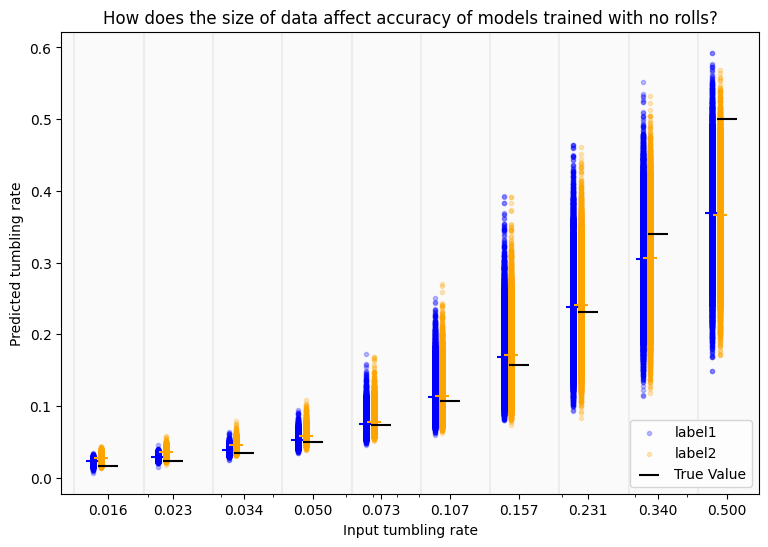

In [9]:
fig,ax=plt.subplots(1,1,figsize=(9,6))

# May need to adjust for 
offsets = [0.92,0.96,1,1.04,1.08]

for i in range(0,len(vArray)):
    array = vArray[i]
    colour = colours[i]
    offset = offsets[i]
    means = listOfMeans[i]

    ax.scatter(y_val*offset, array, c=colour, alpha=0.25, marker=".", label=labels[i])

    # ax.scatter(y_val*offset, np.mean(array), marker="_", color=colour, s=100)
    ax.scatter(np.sort(np.unique(y_val))*offset, means, marker="_", color=colour, s=100)
    

ax.scatter(np.unique(y_val), np.unique(y_val), marker="_", color='k', s=200, label="True Value")

ax.set_xscale("log")
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks(np.unique(y_val))

ax.set_facecolor([0.98,0.98,0.98,1])

for val in bins:
    ax.axvline(val, alpha=0.05, c='k')

ax.set_xlabel("Input tumbling rate")
ax.set_ylabel("Predicted tumbling rate")
ax.set_title("How does the size of data affect accuracy of models trained with no rolls?")

ax.legend()

# plt.savefig("scatter.png")